<a href="https://colab.research.google.com/github/mnshcodie/IIScEx_2021/blob/main/M3_AST_28_Neural_Machine_Translation_with_Custom_Dataset_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Programme in Deep Learning (Foundations and Applications)
## A Program by IISc and TalentSprint
### Assignment 27: Natural Language Processing - III 
### (Translate human readable dates to machine readable dates)

### Learning Objectives:

At the end of the experiment, you will be able to:
 
*  perform seq2seq translation
*  use attention architecture for machine translation tasks
*  Visualize the parts of the input to which every output pays attention to, while doing the translation.


### Setup Steps:

In [ ]:
#@title Please enter your registration id to start: { run: "auto", display-mode: "form" }
Id = "" #@param {type:"string"}

In [ ]:
#@title Please enter your password (normally your phone number) to continue: { run: "auto", display-mode: "form" }
password = "" #@param {type:"string"}

In [ ]:
#@title Run this cell to complete the setup for this Notebook
from IPython import get_ipython
import warnings
warnings.filterwarnings("ignore")

ipython = get_ipython()
  
notebook= "M3_AST_28_Neural_Machine_Translation_with_Custom_Dataset_B" #name of the notebook

def setup():
    ipython.magic("sx wget https://cdn.iisc.talentsprint.com/DLFA/Experiment_related_data/dates_dataset.csv") 

    from IPython.display import HTML, display
    display(HTML('<script src="https://dashboard.talentsprint.com/aiml/record_ip.html?traineeId={0}&recordId={1}"></script>'.format(getId(),submission_id)))
    print("Setup completed successfully")
    return

def submit_notebook():
    ipython.magic("notebook -e "+ notebook + ".ipynb")
    
    import requests, json, base64, datetime

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword()}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:        
        print(r["err"])
        return None        
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None
    
    elif getAnswer1() and getAnswer2() and getComplexity() and getAdditional() and getConcepts() and getComments() and getMentorSupport():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional, 
              "concepts" : Concepts, "record_id" : submission_id, 
              "answer1" : Answer1, "answer2" : Answer2, "id" : Id, "file_hash" : file_hash,
              "notebook" : notebook,
              "feedback_experiments_input" : Comments,
              "feedback_mentor_support": Mentor_support}
      r = requests.post(url, data = data)
      r = json.loads(r.text)
      if "err" in r:        
        print(r["err"])
        return None   
      else:
        print("Your submission is successful.")
        print("Ref Id:", submission_id)
        print("Date of submission: ", r["date"])
        print("Time of submission: ", r["time"])
        print("View your submissions: https://dlfa.iisc.talentsprint.com/notebook_submissions")
        #print("For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.")
        return submission_id
    else: submission_id
    

def getAdditional():
  try:
    if not Additional: 
      raise NameError
    else:
      return Additional  
  except NameError:
    print ("Please answer Additional Question")
    return None

def getComplexity():
  try:
    if not Complexity:
      raise NameError
    else:
      return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None
  
def getConcepts():
  try:
    if not Concepts:
      raise NameError
    else:
      return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None
  
  
# def getWalkthrough():
#   try:
#     if not Walkthrough:
#       raise NameError
#     else:
#       return Walkthrough
#   except NameError:
#     print ("Please answer Walkthrough Question")
#     return None
  
def getComments():
  try:
    if not Comments:
      raise NameError
    else:
      return Comments
  except NameError:
    print ("Please answer Comments Question")
    return None
  

def getMentorSupport():
  try:
    if not Mentor_support:
      raise NameError
    else:
      return Mentor_support
  except NameError:
    print ("Please answer Mentor support Question")
    return None

def getAnswer1():
  try:
    if not Answer1:
      raise NameError 
    else: 
      return Answer1
  except NameError:
    print ("Please answer Question 1")
    return None

def getAnswer2():
  try:
    if not Answer2:
      raise NameError 
    else: 
      return Answer2
  except NameError:
    print ("Please answer Question 2")
    return None
  

def getId():
  try: 
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup 
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup() 
else:
  print ("Please complete Id and Password cells before running setup")



### Importing required packages

In [ ]:
import torch,os
import numpy as np
import pandas as pd
import random,os,sys
from babel.dates import format_date
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm

#### Helper methods for Human readable and machine readable dates

In [ ]:
def transform(human_readable, machine_readable, human_vocab, machine_vocab, human_readable_length):
      
    X = list(map(lambda x: human_vocab.get(x, '<unk>'), human_readable))
    if len(X) < human_readable_length:
        X += [human_vocab['<pad>']] * (human_readable_length - len(X))
    elif len(X) > human_readable_length:
        X = X[:30]
    Y = list(map(lambda x: machine_vocab.get(x, '<unk>'), machine_readable)) #len(Y) is always 10, because the format is YYYY-MM-DD

    def zcs(length, idx):
        ret = np.zeros(length)
        ret[idx] = 1
        return ret
    
    Xoh = np.array(list(map(partial(zcs, len(human_vocab)), X)), dtype=np.float32)
    Yoh = np.array(list(map(partial(zcs, len(machine_vocab)), Y)), dtype=np.float32) 
    return Xoh, Yoh, {'human_readable':human_readable, 'machine_readable':machine_readable}


### Read the csv file as dataframe

In [ ]:
#read the csv file as dataframe
#YOUR CODE HERE

### Dataset Class for reading data

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, transform,dates = dt_train, n_datas=40000, seed=12345):
        self.transform = transform

        self.human_readable = dt_train['human_readable']
        self.machine_readable = dt_train['machine_readable']

        self.human_readable_length = 30 #the maximum length is less than 30
        self.human_vocab = set()
        self.machine_vocab = set()
        self.dataset = []
        
        #read the dataframe and create vocabulary 
        #YOUR CODE HERE

        self.human_vocab = dict(zip(sorted(self.human_vocab) + ['<unk>', '<pad>'], list(range(len(self.human_vocab) + 2))))
        self.inv_machine_vocab = dict(enumerate(sorted(self.machine_vocab)))
        self.machine_vocab = {v:k for k, v in self.inv_machine_vocab.items()}
        

    def __getitem__(self, idx):
        human_readable, machine_readable = self.dataset[idx] #dataset is a list of tuples
        return self.transform(human_readable, machine_readable, self.human_vocab, self.machine_vocab, self.human_readable_length)

    def __len__(self):
        return len(self.dataset)


### Loading data using pytorch data loader

In [ ]:
#Split the dataframe into 40000:10000 train:test split
#YOUR CODE HERE

In [ ]:
dataset = Dataset(dates = dt_train,transform=transform)

In [ ]:
#Load the dataset using Pytorch Dataloader
#YOUR CODE HERE

In [ ]:
for i, batch_x in enumerate(dataloader):
    print(i, batch_x[0].shape, batch_x[1].shape)
    print(batch_x[1])
    if i >= 1:
        break

NMT is a problem where we process an input sequence to produce an output sequence — that is, a sequence-to-sequence (seq2seq) problem. Specifically, the many-to-many type, with a sequence of several elements both at the input and at the output, and the encoder-decoder architecture for recurrent neural networks is the standard method.

Initially machine translation (MT) problems were faced using statistical approaches, based mainly on Bayes probabilities. But when neural networks became more powerful and popular, researchers began to explore the capabilities of this technology and new solutions were found. It is called neural machine translation (NMT).

The model based on RNNs has a serious problem when working with long sequences because the information of the first tokens is lost or diluted as more tokens are processed. The context vector has been given the responsibility of encoding all of the information in a given source sentence into a vector of few hundred elements. It made it challenging for the models to deal with long sentences. 

In this paper https://arxiv.org/pdf/1409.0473.pdf


They introduce a technique called attention, which highly improved the quality of machine-translation systems. “Attention allows the model to focus on the relevant parts of the input sequence as needed, accessing all the past hidden states of the encoder, instead of just the last one”. At each decoding step, the decoder gets to look at any particular state of the encoder and can selectively pick out specific elements from that sequence to produce the output.

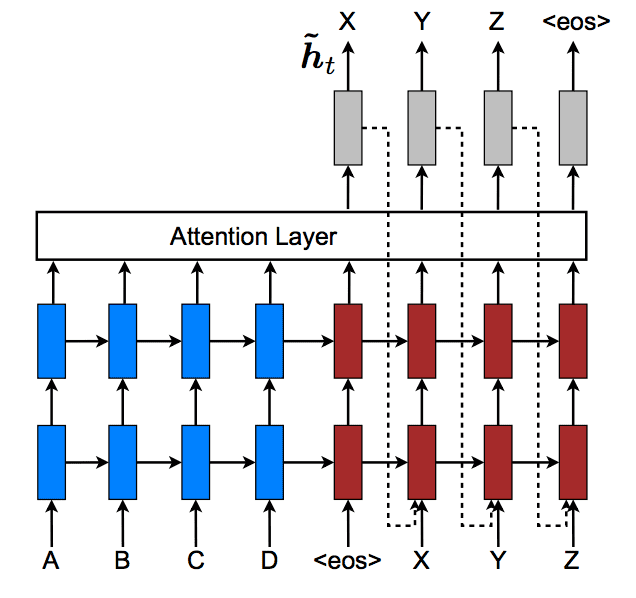

### Encoder architecture

In [ ]:

class Encoder(torch.nn.Module):
    def __init__(self, in_features=37, hidden_size=64):
        super(Encoder, self).__init__()
        #Encoder archiecture
        #YOUR CODE HERE

### Decoder architecture

In [ ]:
class Decoder(torch.nn.Module):
    def __init__(self, in_features=128, hidden_size=128):
        super(Decoder, self).__init__()
        
        #Decoder architecture
        #YOUR CODE HERE


### Combining Encoder-Attention-Decoder

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, output_len, use_gpu=True):
        super(Model, self).__init__()
        self.output_len = output_len
        self.use_gpu = use_gpu
        self.encoder = Encoder(in_features=36, hidden_size=64)
        self.decoder = Decoder(in_features=128, hidden_size=128)
        
        #attention net
        #YOUR CODE HERE

    def forward(self, x):
        feats = self.encoder(x) #(N, 30, 128)
        if self.use_gpu:
            decoder_h = torch.zeros((1, feats.shape[0], 128)).cuda() #(1, N, 128)
            decoder_c = torch.zeros((1, feats.shape[0], 128)).cuda() #(1, N, 128)
        else:
            decoder_h = torch.zeros((1, feats.shape[0], 128)) #(1, N, 128)
            decoder_c = torch.zeros((1, feats.shape[0], 128)) #(1, N, 128)
        # print(feats.shape, decoder_c.shape)
        outputs = []
        self.scores_for_paint = []
        for _ in range(self.output_len):
            feats_2 = decoder_c.transpose(0, 1) #(1, N, 128) --> (N, 1, 128)
            feats_2 = feats_2.repeat(1, feats.shape[1], 1) #(N, 1, 128) --> (N, 30, 128), cuz feats.shape[1] is 30
            feats_in = torch.cat((feats, feats_2), dim=-1) # (N, 30, 128) and (N, 30, 128) --> (N, 30, 256)
            # print(feats.shape, feats_2.shape, feats_in.shape)
            out = self.tanh(self.linear1(feats_in)) #(N, 30, 256) --> (N, 30, 10)
            scores = self.softmax(self.linear2(out)) #(N, 30, 10) --> (N, 30, 1)
            # print(scores[0, :, 0])

            if not self.training:
                self.scores_for_paint.append(scores.squeeze().detach().cpu().numpy())
                # print(scores)
            
            

            feats_for_decoder = torch.mul(feats, scores).sum(axis=1).unsqueeze(1) #(N, 30, 128) mul (N, 30, 1) --> (N, 30, 128) --> (N, 128) --> (N, 1, 128)
            

            decoder_out, (decoder_h, decoder_c) = self.decoder(feats_for_decoder, decoder_h, decoder_c) #run lstm only one step, cuz feats_for_decoder.shape is (N, 1, 128)
            outputs.append(decoder_out.unsqueeze(1)) #list of (N, 1, 11)
            # print(decoder_out.shape)
        outputs = torch.cat(outputs, dim=1) #(N, 10, 11) 10是输出序列长度
        # print(outputs.shape)
        return outputs

    def total_parameters(self):
        return sum([p.numel() for p in self.parameters()])

In [ ]:


model = Model(output_len=13, use_gpu=False)
print('model size is %.3f KB' % (model.total_parameters() * 4 / 1024))


### Helper function for calculating accuracy

In [ ]:
#Method for calculaing accuracy
#YOUR CODE HERE

### Helper function for training the attention network

In [ ]:
def train(model, loss_fn, optimizer, dataloader, epoch, use_gpu=False):
    pbar = tqdm(total=len(dataloader), bar_format='{l_bar}{r_bar}', dynamic_ncols=True)
    pbar.set_description(f'Epoch %d' % epoch)

    for step, (batch_x, batch_y, _) in enumerate(dataloader):
        
        #code for training the model and calculate loss
        #YOUR CODE HERE

        pbar.set_postfix(**{'loss':loss.detach().cpu().item(), 'accuracy':accuracy})
        pbar.update()
    save_checkpoint('./checkpoint', epoch, model, optimizer)

    pbar.close()

### Saving the model checkpoints

In [ ]:
def find_last_checkpoint(checkpoint_dir):
    epochs = []
    for name in os.listdir(checkpoint_dir):
        if os.path.splitext(name)[-1] == '.pth':
            epochs += [int(name.strip('ckpt_epoch_.pth'))]
    if len(epochs) == 0:
        raise IOError('no checkpoint found in {}'.format(checkpoint_dir))
    return max(epochs)

def save_checkpoint(checkpoint_dir, epoch, model, optimizer=None):
    checkpoint = {}
    checkpoint['epoch'] = epoch

    if isinstance(model, torch.nn.DataParallel):
        model_state_dict = model.module.state_dict()
    else:
        model_state_dict = model.state_dict()
    checkpoint['model'] = model_state_dict

    if optimizer is not None:
        optimizer_state_dict = optimizer.state_dict()
        # for k, v in optimizer_state_dict.items():
        #     print(k, type(v))
        # optimizer_state_dict = rename_dict_key(optimizer_state_dict)
        checkpoint['optimizer'] = optimizer_state_dict
    else:
        checkpoint['optimizer'] = None

    torch.save(checkpoint, os.path.join(checkpoint_dir, 'ckpt_epoch_%02d.pth'% epoch))

def load_checkpoint(checkpoint_dir, epoch=-1):
    if epoch == -1:
        epoch = find_last_checkpoint(checkpoint_dir)
    checkpoint_name = 'ckpt_epoch_%02d.pth'% epoch
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)
    ckpt = torch.load(checkpoint_path, map_location='cpu')
    return ckpt

def save_model(checkpoint_dir, epoch, model):
    save_checkpoint(checkpoint_dir, epoch, model, optimizer=None)

def load_model(checkpoint_dir, epoch, model):
    try:
        ckpt = load_checkpoint(checkpoint_dir, epoch)
        model_state_dict = ckpt['model']

        if isinstance(model, torch.nn.DataParallel):
            model.module.load_state_dict(model_state_dict)
        # elif isinstance(model, torchDDP):
        #     model.module.load_state_dict(model_state_dict)
        # elif isinstance(model, apexDDP):
        #     model.module.load_state_dict(model_state_dict)
        else:
            model.load_state_dict(model_state_dict)
    except Exception as e:
        print('failed to load model, {}'.format(e))
    return model

def load_optimizer(checkpoint_dir, epoch, optimizer):
    try:
        ckpt = load_checkpoint(checkpoint_dir, epoch)
        optimizer_state_dict = ckpt['optimizer']
        optimizer.load_state_dict(optimizer_state_dict)
    except Exception as e:
        print('failed to load optimizer, {}'.format(e))
    return optimizer

### Training the model

In [ ]:
if not os.path.exists("checkpoint"):
  os.mkdir("checkpoint")

In [ ]:
def main(dataloader,gpu_id=None,):

    dataloader = dataloader

    #Initiate and train the model
    #YOUR CODE HERE

    model = load_model('./checkpoint', -1, model)
    optimizer = load_optimizer('./checkpoint', -1, optimizer)

    try:
        trained_epoch = find_last_checkpoint('./checkpoint')
        print('train form epoch %d' % (trained_epoch + 1))
    except Exception as e:
        print('train from the very begining, {}'.format(e))
        trained_epoch = -1
    for epoch in range(trained_epoch+1, 20):
        train(model, loss_fn, optimizer, dataloader, epoch, use_gpu=True if gpu_id is not None else False)


if len(sys.argv) == 1:
    main(dataloader,gpu_id='0')
else:
    main(dataloader,gpu_id=None)

### Testing the model with 10000 test examples

In [ ]:
#load the dataset for testing model

### Evaluating the model 
#### Here we are evaulating the model and plotting the attention

In [ ]:

model = Model(output_len=10, use_gpu=False)
try:
    trained_epoch = find_last_checkpoint('./checkpoint')
    print('load model %d' % (trained_epoch))
except Exception as e:
    print('no trained model found, {}'.format(e))

model = load_model('./checkpoint', -1, model)
model.eval()


#Plot the attention plots of test data 
#YOUR CODE HERE


### Calculating the accuracy

In [ ]:
#Calculate the test set accuracy
#YOUR CODE HERE

### Please answer the questions below to complete the experiment:




In [ ]:
#@title Q.1. In the encoder, the fixed length vector at the output represents _______________  ?
Answer1 = "" #@param ["","Word vector","Encoding of the input sentence","Translation of the sentence","Softmax containing the probability score of all words in the vocabulary"]


In [ ]:
#@title Q.2. Why is an RNN (Recurrent Neural Network) used for machine translation,say translating English to German ? 
Answer2 = "" #@param ["","RNNs do not have problem of vanishing gradient","It is strictly powerful than a Convolutional Neural Network(CNN)","It is applicable when the input/output is a sequence (e.g., a sequence of words)","None of the above"]


In [ ]:
#@title How was the experiment? { run: "auto", form-width: "500px", display-mode: "form" }
Complexity = "" #@param ["","Too Simple, I am wasting time", "Good, But Not Challenging for me", "Good and Challenging for me", "Was Tough, but I did it", "Too Difficult for me"]


In [ ]:
#@title If it was too easy, what more would you have liked to be added? If it was very difficult, what would you have liked to have been removed? { run: "auto", display-mode: "form" }
Additional = "" #@param {type:"string"}


In [ ]:
#@title Can you identify the concepts from the lecture which this experiment covered? { run: "auto", vertical-output: true, display-mode: "form" }
Concepts = "" #@param ["","Yes", "No"]


In [ ]:
#@title  Text and image description/explanation and code comments within the experiment: { run: "auto", vertical-output: true, display-mode: "form" }
Comments = "" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [ ]:
#@title Mentor Support: { run: "auto", vertical-output: true, display-mode: "form" }
Mentor_support = "" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [ ]:
#@title Run this cell to submit your notebook for grading { vertical-output: true }
try:
  if submission_id:
      return_id = submit_notebook()
      if return_id : submission_id = return_id
  else:
      print("Please complete the setup first.")
except NameError:
  print ("Please complete the setup first.")